In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2

import os
from keras.applications.densenet import DenseNet201

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Read input images and assign labels based on folder names
print(os.listdir("/content/drive/MyDrive/Project/projectdatasets(50-50)"))

SIZE = 64 #Resize images

['test', 'train']


In [4]:
#Capture training data and labels into respective lists
train_images = []
train_labels = [] 

for directory_path in glob.glob("/content/drive/MyDrive/Project/projectdatasets(50-50)/train/*"):
    label = directory_path.split("/")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*")):
        #print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(label)

#Convert lists to arrays        
train_images = np.array(train_images)
train_labels = np.array(train_labels)

Normal
Myeloma
Leukemia


In [6]:
train_images.shape

(3000, 64, 64, 3)

In [7]:
# Capture test/validation data and labels into respective lists

test_images = []
test_labels = [] 
for directory_path in glob.glob("/content/drive/MyDrive/Project/projectdatasets(50-50)/test/*"):
    fruit_label = directory_path.split("/")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(fruit_label)

#Convert lists to arrays                
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [8]:
test_images.shape

(3000, 64, 64, 3)

In [9]:
np.unique(train_labels)

array(['Leukemia', 'Myeloma', 'Normal'], dtype='<U8')

In [10]:
#Encode labels from text to integers.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [11]:
print(np.unique(train_labels_encoded))

[0 1 2]


In [12]:
#Split data into test and train datasets (already split but assigning to meaningful convention)
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [13]:
#Normalize pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

In [14]:
#Load model wothout classifier/fully connected layers
Dnet_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in Dnet_model.layers:
	layer.trainable = False
    
Dnet_model.summary()  #Trainable parameters will be 0

74850304/74836368 [==============================] - 0s 0us/step
Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 32, 32, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1/conv[0][0]']             
                       

In [15]:
#Now, let us use features from convolutional network for RF
feature_extractor = Dnet_model.predict(x_train)

features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_for_training = features #This is our X input to RF

In [16]:
X_for_training.shape

(3000, 7680)

In [17]:
#XGBOOST
import xgboost as xgb
model = xgb.XGBClassifier(tree_method='gpu_hist', gpu_id=0)
model.fit(X_for_training, y_train) #For sklearn no one hot encoding


XGBClassifier(gpu_id=0, objective='multi:softprob', tree_method='gpu_hist')

In [18]:
#Send test data through same feature extractor process
X_test_feature = Dnet_model.predict(x_test)
print(X_test_feature.shape)

(3000, 2, 2, 1920)


In [19]:
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

In [20]:
print(X_test_feature.shape)

(3000, 2, 2, 1920)


In [21]:
print(X_test_features.shape)

(3000, 7680)


In [22]:
#Now predict using the trained RF model. 
prediction = model.predict(X_test_features)
#Inverse le transform to get original label back. 
prediction = le.inverse_transform(prediction)

In [23]:
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction))

Accuracy =  0.926


**Precision Score , Recall Score , Accuracy Score , F1 Score**

In [24]:
#Precision Score
print("Precision = ", metrics.precision_score(test_labels, prediction,average='micro'))

#Recall
print("Recall = ", metrics.recall_score(test_labels, prediction,average='micro'))

#Accuracy Score
print("Accuracy = ", metrics.accuracy_score(test_labels, prediction))

#F1 score
print("F1 Score = ", metrics.f1_score(test_labels, prediction,average='micro'))

Precision =  0.926
Recall =  0.926
Accuracy =  0.926
F1 Score =  0.926


**Confusion Matrix**

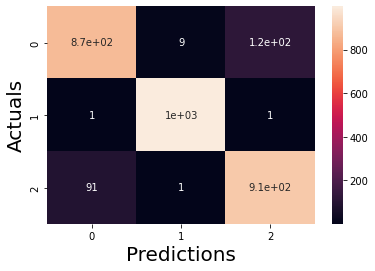

In [25]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(test_labels, prediction)
#print(cm)
sns.heatmap(cm, annot=True)



plt.xlabel('Predictions', fontsize=20)
plt.ylabel('Actuals', fontsize=20)
plt.show()

The prediction for this image is:  ['Leukemia']
The actual label for this image is:  Leukemia


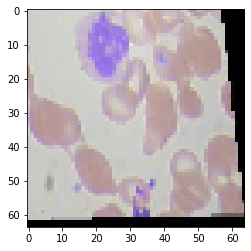

In [26]:
#Check results on a few select images
n=np.random.randint(0, x_test.shape[0])
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_feature=Dnet_model.predict(input_img)
input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
prediction = model.predict(input_img_features)[0]
prediction = le.inverse_transform([prediction])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction)
print("The actual label for this image is: ", test_labels[n])

In [27]:
from joblib import dump, load
dump(model, 'dn_xgb50.joblib')
model1 = load('dn_xgb50.joblib')

The prediction for this image is:  ['Normal']
The actual label for this image is:  Normal


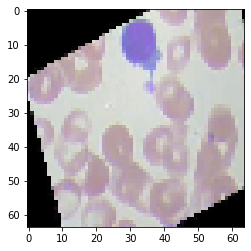

In [28]:
#Check results on a few select images
n=np.random.randint(0, x_test.shape[0])
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_feature=Dnet_model.predict(input_img)
input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
prediction = model1.predict(input_img_features)[0] 
prediction = le.inverse_transform([prediction])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction)
print("The actual label for this image is: ", test_labels[n])